# Support Vector Machines

Support Vector Machines (SVM) are an extension of the linear methods that attempt to separate classes with hyperplans.

These extensions come in three steps:
1. When classes are linearly separable, maximize the margin between the two classes
2. When classes are not linearly separable, maximize the margin but allow some samples within the margin. That is the soft margin
3. The "Kernel trick" to extend the separation to non linear frontieres

The boost in performance of the Kernel trick has made the SVM the best classification method of the 2000's until the deep neural nets.

### Learning goals

- Understand and implement SVM concepts stated above
- Reminder to the Lagrange multiplier and optimization theory
- Deal with a general purpose solver with constraints
- Apply SVM to a non linear problem (XOR) with a non linear kernel (G-RBF)

### References

- [1] [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/) - Trevor Hastie, Robert Tibshirani, Jerome Friedman, Springer
- [2] Convex Optimization - Stephen Boyd, Lieven Vandenberghe, Cambridge University Press
- [3] [Pattern Recognition and Machine Learning - Ch 7 demo](https://github.com/yiboyang/PRMLPY/blob/master/ch7/svm.py) - Christopher M Bishop, Github

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

## Helpers

In [2]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

## The data model

Let's use a simple model with two Gaussians that are faraway in order to be separable

In [3]:
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100

In [4]:
def generateBatchBipolar(n, mu=0.5, sigma=0.2):
    """ Two gaussian clouds on each side of the origin """
    X = np.random.normal(mu, sigma, (n, 2))
    yB = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y = 2. * yB - 1
    X *= y[:, np.newaxis]
    X -= X.mean(axis=0)
    return X, y

# 1. Maximum margin separator

The following explanation is about the binary classification but generalizes to more classes.

Let $X$ be the matrix of $n$ samples of the $p$ features. We want to separate the two classes of $y$ with an hyperplan (a straight line in 2D, that is $p=2$). The separation equation is:

$$ w^T x + b = 0, w \in \mathbb{R}^{p}, x \in \mathbb{R}^{p}, b \in \mathbb{R} $$

Given $x_0$ a point on the hyperplan, the signed distance of any point $x$ to the hyperplan is :
$$ \frac{w}{\Vert w \Vert} (x - x_0) = \frac{1}{\Vert w \Vert} (w^T x + b) $$

If $y$, such that $y \in \{-1, 1\}$, is the corresponding label of $x$, the (unsigned) distance is : 
$$ \frac{y}{\Vert w \Vert} (w^T x + b) $$

This is the update quantity used by the Rosenblatt Perceptron.

The __Maximum margin separator__ is aiming at maximizing $M$ such that : 
$$ \underset{w, b}{\max} M $$
__Subject to :__
- $y_i(x_i^T w + b) \ge M, i = 1..n$
- $\Vert w \Vert = 1$

$x_i$ and $y_i$ are samples of $x$ and $y$, a row of the matrix $X$ and the vector $y$.

However, we may change the condition on the norm of $w$ such that : $\Vert w \Vert = \frac 1M$

Leading to the equivalent statement of the maximum margin classifier : 
$$ \min_{w, b} \frac 12 \Vert w \Vert^2 $$
__Subject to : $y_i(x_i^T w + b) \ge 1, i = 1..n$__ 

For more details, see [1, chap 4.5]

The corresponding Lagrange primal problem is :

$$\mathcal{L}_p(w, b, \alpha) = \frac 12 \Vert w \Vert^2 - \sum_{i=0}^n \alpha_i (y_i(x_i^T w + b) - 1)$$

__Subject to:__
- $\alpha_i \ge 0, i\in 1..n$

This shall be __minimized__ on $w$ and $b$, using the corresponding partial derivates equal to 0, we get : 
$$\begin{align}
\sum_{i=0}^n \alpha_i y_i x_i &= w \\
\sum_{i=0}^n \alpha_i y_i &= 0
\end{align}$$

From $\mathcal{L}_p$, we get the (Wolfe) dual : 
$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k x_i^T x_k \\
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \langle \alpha_i y_i x_i, \alpha_k y_k  x_k \rangle \\
\end{align}$$

__Subject to :__
- $\alpha_i \ge 0, i\in 1..n$
- $\sum_{i=0}^n \alpha_i y_i = 0$

Which is a concave problem that is __maximized__ using a solver.

Strong duality requires (KKT) [2, chap. 5.5]: 
- $\alpha_i (y_i(x_i^T w + b) - 1) = 0,  \forall i \in 1..n$

Implying that : 
- If $\alpha_i > 0$, then $y_i(x_i^T w + b) = 1$, meaning that $x_i$ is on one of the two hyperplans located at the margin distance from the separating hyperplan. $x_i$ is said to be a support vector
- If $y_i(x_i^T w + b) > 1$, the distance of $x_i$ to the hyperplan is larger than the margin.

### Train data

To demonstrate the maximum margin classifier, a dataset with separable classes is required. Let's use a mixture of two gaussian distributed classes with mean and variance such that the two classes are separated.

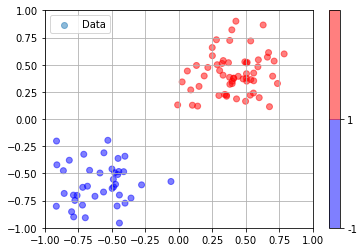

In [5]:
xTrain0, yTrain0 = generateBatchBipolar(N, sigma=0.2)
plotSvm(xTrain0, yTrain0)

## Implementation of the Maximum margin separator

$$\mathcal{L}_d = \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k x_i^T x_k $$

__Subject to :__
- $\sum_{i=0}^n \alpha_i y_i = \langle \alpha, y \rangle = 0$
- $\alpha_i \ge 0, i\in 1..n$

The classifier is built on the scipy.optimize.minimum solver. The implementation is correct but inefficient as it is not taking into account for the sparsity of the $\alpha$ vector.

In [6]:
class MaxMarginClassifier:
    
    def __init__(self):
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (X.y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = -np.eye(N)
        b = np.zeros(N)
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        # Any support vector is at a distance of 1 to the separation plan
        # => use support vector #0 to compute the intercept, assume label is in {-1, 1}
        supportLabels = y[self.alpha > epsilon]
        self.intercept = supportLabels[0] - np.matmul(self.supportVectors[0].T, self.w)
    
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * (np.matmul(X, self.w) > 0) - 1

Reference: 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [7]:
model00 = MaxMarginClassifier()
model00.fit(xTrain0, yTrain0)
model00.w, model00.intercept

(array([2.16003612, 2.68614007]), 0.6676704259779964)

Number of support vectors = 3


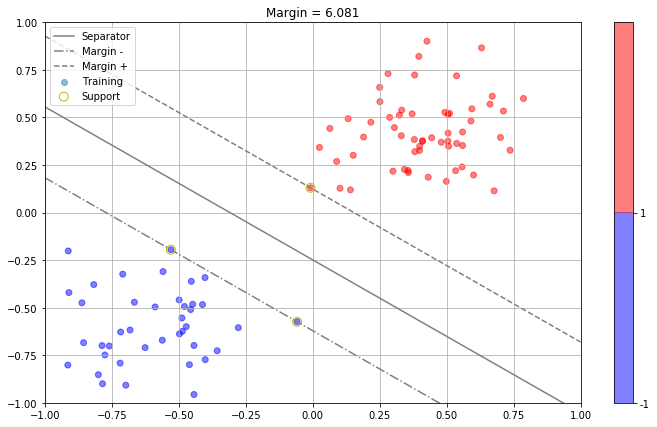

In [8]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(xTrain0, yTrain0, model00.supportVectors, model00.w, model00.intercept, label='Training', ax=ax)

## Maximum margin classifier using Scikit Learn (SVC)

SVC is used in place of LinearSVC as the support vectors are provided. These vectors are displayed in the graph here below.

Set a high $C$ parameter to disable soft margin

In [9]:
model01 = svm.SVC(kernel='linear', gamma='auto', C = 1e6)
model01.fit(xTrain0, yTrain0)
model01.coef_[0], model01.intercept_[0]

(array([2.16036395, 2.68538166]), 0.6675306727455773)

Number of support vectors = 3


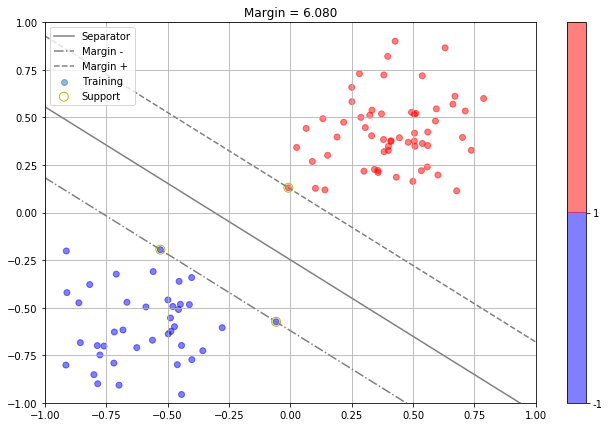

In [10]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain0, yTrain0, model01.support_vectors_, model01.coef_[0], model01.intercept_[0], 
        label='Training', ax=ax)

The two implementations of the linear SVM agree on the ceofficients and margin. Good !

### Comparison of the maximum margin classifier to the Logistic regression and Linear Discriminant Analysis (LDA)

Logistic regression is based on the linear regression that is the computation of the square error of any point $x$ to the separation plan and a projection on the probability space using the sigmoid in order to compute the binary cross entropy, see ([HTML](ClassificationContinuous2Features.html) / [Jupyter](ClassificationContinuous2Features.ipynb)).

LDA is assuming a Gaussian mixture prior (our case) and performs bayesian inference.

In [11]:
model02 = linear_model.LogisticRegression(solver='lbfgs')
model02.fit(xTrain0, yTrain0)
model02.coef_[0], model02.intercept_[0]

(array([2.74961421, 2.8640208 ]), 0.7261643942525459)

In [12]:
model03 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model03.fit(xTrain0, yTrain0)
model03.coef_[0], model03.intercept_[0]

(array([24.85481733, 24.06796222]), 4.833457149444095)

We observe that the coefficients of the three models are very different in amplitude but globally draw a separator line with slope $-\frac \pi4$ in the 2D plan

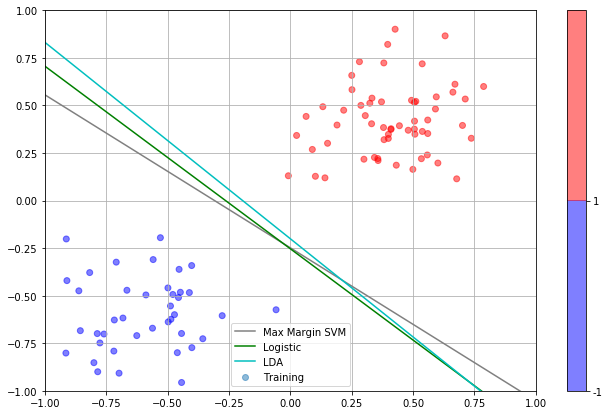

In [13]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain0, yTrain0, w=model01.coef_[0], intercept=model01.intercept_[0], 
        separatorLabel='Max Margin SVM', label='Training', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model02.coef_[0], x0=model02.intercept_[0], label='Logistic', color='g')
plotLine(ax, xx, w=model03.coef_[0], x0=model03.intercept_[0], label='LDA', color='c')
ax.legend();

# 2. Soft Margin Linear SVM for non separable classes

The example above has little interest as the separation is trivial.

Using the same SVM implementation on a non separable case would not be possible, the solver would fail.

Here comes the soft margin: some $x_i$ are allowed to lie in between the two margin bars.

The __Soft margin linear SVM__ is adding a regularization parameter in maximizing $M$: 

$$ \underset{w, b}{\max} M ( 1 - \xi_i) $$
__Subject to $\forall i = 1..n$:__
- $y_i(x_i^T w + b) \ge M$
- $\Vert w \Vert = 1$
- $\xi_i \ge 0$

Equivalently :
$$ \min_{w, b} \frac 12 \Vert w \Vert^2 + C \sum_{i=1}^n \xi_i$$
__Subject to $\forall i = 1..n$:__
- $\xi_i \ge 0$
- $y_i(x_i^T w + b) \ge 1 - \xi_i$

The corresponding Lagrange primal problem is :

$$\mathcal{L}_p(w, b, \alpha, \mu) = \frac 12 \Vert w \Vert^2 - \sum_{i=0}^n \alpha_i (y_i(x_i^T w + b) - (1 - \xi_i) - \sum_{i=0}^n \mu_i \xi_i  $$

__Subject to $\forall i\in 1..n$:__
- $\alpha_i \ge 0$
- $\mu_i \ge 0$
- $\xi_i \ge 0$

This shall be minimized on $w$, $b$ and $\xi_i$, using the corresponding partial derivates equal to 0, we get : 
$$\begin{align}
\sum_{i=0}^n \alpha_i y_i x_i &= w \\
\sum_{i=0}^n \alpha_i y_i &= 0 \\
\alpha_i &= C - \mu_i
\end{align}$$

From $\mathcal{L}_p$, we get the (Wolfe) dual : 
$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k x_i^T x_k \\
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \langle \alpha_i y_i x_i, \alpha_k y_k  x_k \rangle \\
\end{align}$$

__Subject to $\forall i\in 1..n$:__
- $0 \le \alpha_i \le C$
- $\sum_{i=0}^n \alpha_i y_i = 0$

This problem is very similar to the one of the Maximum margin separator, but with one more constraint on $\alpha$.

It is a concave problem that is maximized using a solver.

Extra conditions to get strong duality are required (KKT), $\forall i \in 1..n$:
- $\alpha_i (y_i(x_i^T w + b) - (1 - \xi_i)) = 0$
- $\mu_i \xi_i = 0$
- $y_i(x_i^T w + b) - (1 - \xi_i) \ge 0$

More detailed explainations are in [1 chap. 12.1, 12.2]

## Data model

Let's reuse the same model made of two gaussians, but with larger variance in order to mix the positive and negative points

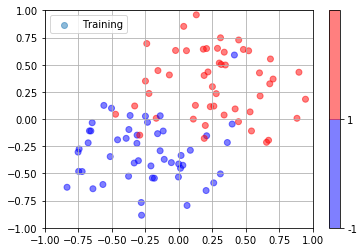

In [14]:
xTrain1, yTrain1 = generateBatchBipolar(N, mu=0.3, sigma=0.3)
plotSvm(xTrain1, yTrain1, label='Training')

## Custom implementation

Changes to the Maximum margin classifier are identified by "# <---"

In [16]:
class LinearSvmClassifier:
    
    def __init__(self, C):
        self.C = C                                 # <---
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (X.y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        # Support vectors is at a distance <= 1 to the separation plan
        # => use min support vector to compute the intercept, assume label is in {-1, 1}
        signedDist = np.matmul(self.supportVectors, self.w)
        minDistArg = np.argmin(signedDist)
        supportLabels = y[self.alpha > epsilon]
        self.intercept = supportLabels[minDistArg] - signedDist[minDistArg]
    
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * (np.matmul(X, self.w) > 0) - 1

In [19]:
model10 = LinearSvmClassifier(C=1)
model10.fit(xTrain1, yTrain1)
model10.w, model10.intercept

(array([2.16498036, 2.66944475]), 0.06828423469101663)

Number of support vectors = 38


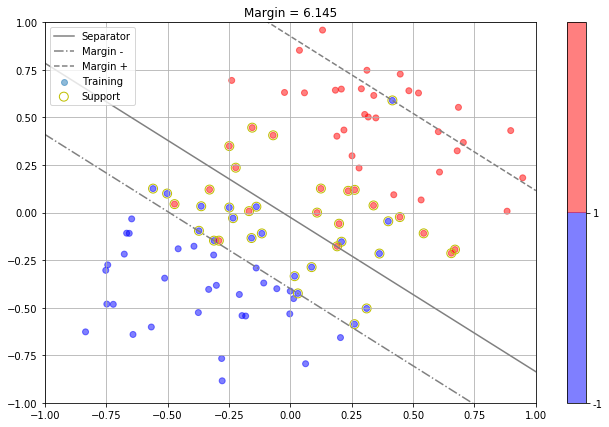

In [20]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, model10.supportVectors, model10.w, model10.intercept, label='Training', ax=ax)

### Linear SVM using Scikit Learn

In [21]:
model11 = svm.SVC(kernel='linear', gamma='auto', C = 1)
model11.fit(xTrain1, yTrain1)
model11.coef_[0], model11.intercept_[0]

(array([2.16469644, 2.67061735]), 0.0678533291918688)

Number of support vectors = 37


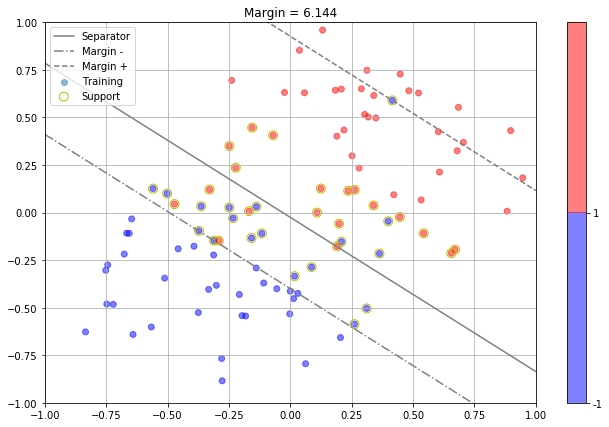

In [22]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, model11.support_vectors_, model11.coef_[0], model11.intercept_[0], 
        label='Training', ax=ax)

With the soft margin, the support vectors are all the vectors on the boundary or within the margin slab.

The custom and SKLearn implementations are matching !

### Comparison of the soft margin classifier to the Logistic regression and Linear Discriminant Analysis (LDA)

In [23]:
model12 = linear_model.LogisticRegression(solver='lbfgs')
model12.fit(xTrain1, yTrain1)
model12.coef_[0], model12.intercept_[0]

(array([2.15539671, 3.13862234]), -0.027537842621387962)

In [24]:
model13 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model13.fit(xTrain1, yTrain1)
model13.coef_[0], model13.intercept_[0]

(array([4.67049164, 7.63316048]), -0.11304860223022994)

As shown below, the three models separator hyperplans are very similar, negative slope.

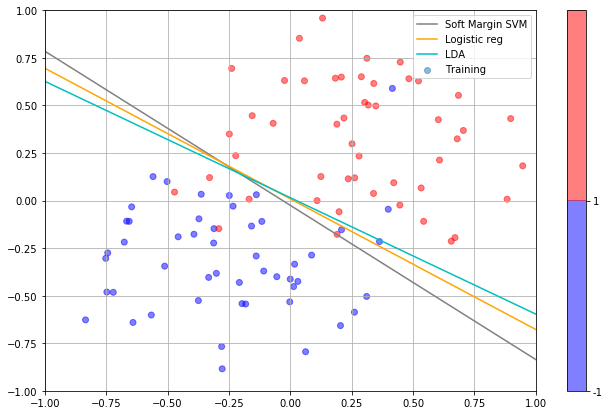

In [25]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, w=model11.coef_[0], intercept=model11.intercept_[0], label='Training',
        separatorLabel='Soft Margin SVM', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model12.coef_[0], x0=model12.intercept_[0], label='Logistic reg', color='orange')
plotLine(ax, xx, w=model13.coef_[0], x0=model13.intercept_[0], label='LDA', color='c')
ax.legend();

### Validation with test data

In [26]:
xTest1, yTest1 = generateBatchBipolar(2*N, mu=0.3, sigma=0.3)

#### Helpers for binary classification performance

In [27]:
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');

### Confusion matrices

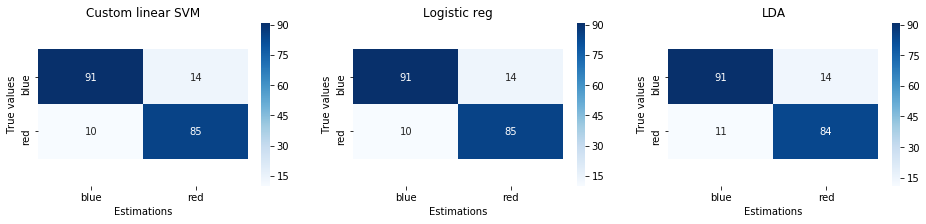

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3))
for model, ax, title in zip([model10, model12, model13], axes, ['Custom linear SVM', 'Logistic reg', 'LDA']):
    yEst = model.predict(xTest1)
    plotConfusionMatrix(yTest1, yEst, colors, title, ax=ax)

There is no clear winner, all models are performing equally well.

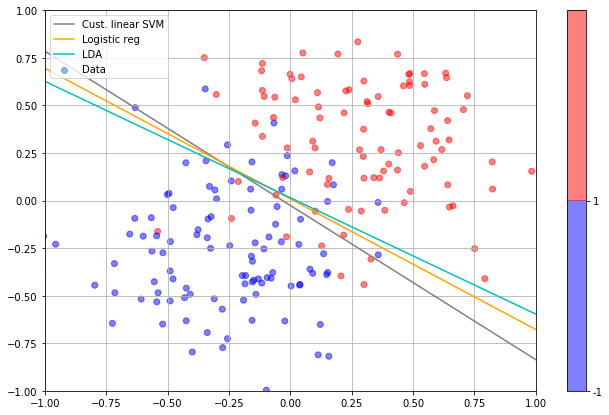

In [29]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTest1, yTest1, w=model10.w, intercept=model10.intercept, separatorLabel='Cust. linear SVM', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model12.coef_[0], x0=model12.intercept_[0], label='Logistic reg', color='orange')
plotLine(ax, xx, w=model13.coef_[0], x0=model13.intercept_[0], label='LDA', color='c')
ax.legend();

# 3. The "kernel trick" for non linearly separable classes

Let's use a very famous dataset showing the main limitation of the Logistic regression and LDA : the XOR.

In [30]:
def generateBatchXor(n, mu=0.5, sigma=0.5):
    """ Four gaussian clouds in a Xor fashion """
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:,0] *= y0
    X[:,1] *= y1
    X -= X.mean(axis=0)
    return X, y0*y1

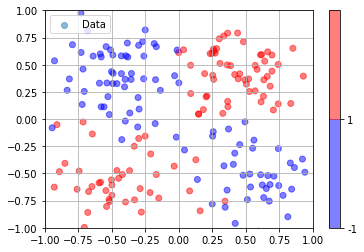

In [31]:
xTrain3, yTrain3 = generateBatchXor(2*N, sigma=0.25)
plotSvm(xTrain3, yTrain3)
xTest3, yTest3 = generateBatchXor(2*N, sigma=0.25)

## Logistic regression and LDA on XOR problem

In [32]:
model32 = linear_model.LogisticRegression(solver='lbfgs')
model32.fit(xTrain3, yTrain3)
model32.coef_[0], model32.intercept_[0]

(array([ 0.18313949, -0.04453478]), 0.04011776028832016)

In [33]:
model33 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model33.fit(xTrain3, yTrain3)
model33.coef_[0], model33.intercept_[0]

(array([ 0.1935286 , -0.04691165]), 0.04012666146020827)

The linear separators are sometimes mitigating the issue by isolating a single class within a corner. Or they are simply fully failing (separator is of limit).

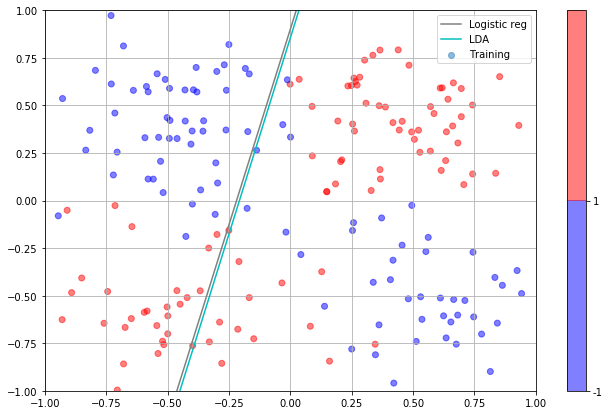

In [34]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, w=model32.coef_[0], intercept=model32.intercept_[0], label='Training',
        separatorLabel='Logistic reg', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model33.coef_[0], x0=model33.intercept_[0], label='LDA', color='c')
ax.legend();

## Introducing the Kernel trick

When using linear separators like the regression, the traditional way to deal with non linear functions is to expand the feature space using powers and products of the initial features. This is also necessary in case of multiclass problems as shown in [1 chap. 4.2].

There are limits to this trick. For example, the XOR problem is not handled proprely.

The SVM has used a new method known as the "Kernel trick".

Let's apply a transformation to $x$ using function $h(x)$. 

The Lagrange (Wolfe) dual problem becomes : 
$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k h(x_i)^T h(x_k) \\
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k \langle y_i h(x_i), y_k  h(x_k) \rangle \\
\end{align}$$

__Subject to $\forall i\in 1..n$:__
- $0 \le \alpha_i \le C$
- $\sum_{i=0}^n \alpha_i y_i = 0$

Since $ w = \sum_{i=0}^n \alpha_i y_i h(x_i)$, the prediction function is now : 
$$ f(x) = sign(w^T h(x) + b) = sign \left(\sum_{i=0}^n \alpha_i y_i \langle h(x_i), h(x) \rangle \right) $$

This prediction needs to be computed for $\alpha_i > 0$, that are support vectors.

Both the fit and prediction are based on the inner product $K(x, x') = \langle h(x), h(x') \rangle$, also known as the kernel function. This function shall be symmetric, semi-definite.

Popular kernel is the Gaussian Radial Basis Function (RBF) : $K(x, x') = exp(- \gamma \Vert x - x' \Vert^2 )$

### Custom implementation of the SVM with G-RBF kernel

Modifications made on the Linear SVM implementation are enclosed in blocks starting with _"# --->"_ and ending with _"# <---"_

In [35]:
class KernelSvmClassifier:
    
    def __init__(self, C, kernel):
        self.C = C                               
        self.kernel = kernel          # <---
        self.alpha = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # --->
        # Gram matrix of h(x) y
        hXX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X),
                                  1, X)   
        yp = y.reshape(-1, 1)
        GramHXy = hXX * np.matmul(yp, yp.T) 
        # <---

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramHXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramHXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        # --->
        epsilon = 1e-8
        supportIndices = self.alpha > epsilon
        self.supportVectors = X[supportIndices]
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
        # <---
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        # --->
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, X)
        return 2 * (d > 0) - 1
        # <---

In [36]:
def GRBF(x1, x2):
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * len(x1) / 2)

model30 = KernelSvmClassifier(C=5, kernel=GRBF)
model30.fit(xTrain3, yTrain3)

Number of support vectors = 52


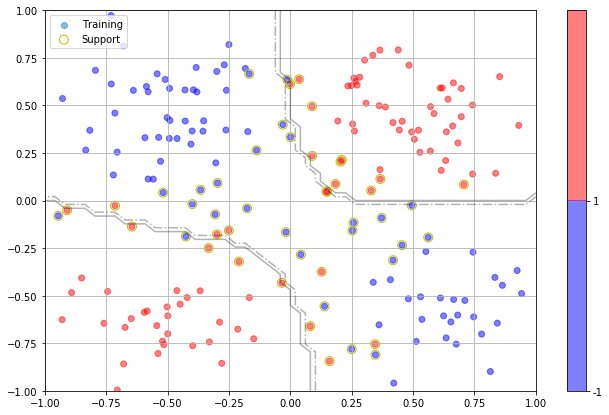

In [37]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=model30.supportVectors, label='Training', ax=ax)

# Estimate and plot decision boundary
xx = np.linspace(-1, 1, 50)
X0, X1 = np.meshgrid(xx, xx)
xy = np.vstack([X0.ravel(), X1.ravel()]).T
Y30 = model30.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y30, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

## Scikit Learn SVM with Radial basis kernel

In [38]:
model31 = svm.SVC(kernel='rbf', C=10, gamma=1/2, shrinking=False)
model31.fit(xTrain3, yTrain3);

Number of support vectors = 54


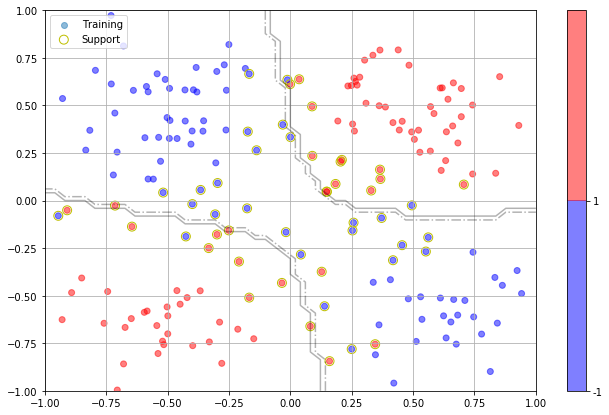

In [39]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=model31.support_vectors_, label='Training', ax=ax)

# Estimate and plot decision boundary
Y31 = model31.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y31, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

### SVM with RBF performance on XOR

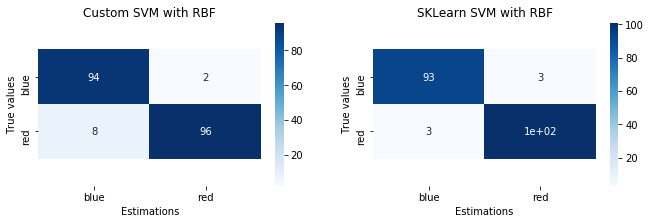

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))
for model, ax, title in zip([model30, model31], axes, ["Custom SVM with RBF", "SKLearn SVM with RBF"]):
    yEst3 = model.predict(xTest3)
    plotConfusionMatrix(yTest3, yEst3, colors, title, ax=ax)

Both models' predictions are almost matching on the XOR example.

## Conclusion

We have shown the power of SVM classifiers for non linearly separable problems. From the end of the 1990's, SVM was the leading machine learning algorithm family for many problems. This situation has changed a little since 2010 as deep learning has shown better performance for some classes of problems. However, SVM remains stronger in many contexts. For example, the amount of training data for SVM is lower than the one required for deep learning.

### Where to go from here

- Multiclass classifier using Neural Nets in Keras ([HTML](ClassificationMulti2Features-Keras.html) / [Jupyter](ClassificationMulti2Features-Keras.ipynb))
- Multiclass classifier using Decision Trees ([HTML](ClassificationMulti2Features-Tree.html) / [Jupyter](ClassificationMulti2Features-Tree.ipynb))
- Bivariate continuous function approximation with Linear Regression ([HTML](ClassificationContinuous2Features.html) / [Jupyter](ClassificationContinuous2Features.ipynb))
- Bivariate continuous function approximation with k Nearest Neighbors ([HTML](ClassificationContinuous2Features-KNN.html) / [Jupyter](ClassificationContinuous2Features-KNN.ipynb))